# Vector Space Semantics for Similarity between Eastenders Characters

In this project, we will create a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates we can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for us to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. We need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Steps 1-4 below, which we need to complete as instructed.



In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction import DictVectorizer

import contractions

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

## 1. Improve pre-processing
Using the pre-processing to improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric we need to focus on improving throughout this project, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- we should be looking to improve those, particularly getting the mean rank as close to 1 as possible.

In [6]:
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
def clean_tokenization(text):
    return word_tokenize(text)

from nltk.stem import PorterStemmer
porter_stemmer=PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
def remove_stopw(text):
    if text not in stopwords.words('english'):
        return text
    
def clean_punct(text):
    if text == '_eol_':
        return ('_eol_')
    else:
        text = re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^`{|}~]+', ' ', text)
        return (re.sub(' +', ' ', text))

def keep_char(text):
    if text == '_eol_':
        return ('_eol_')
    else:
        text = re.sub('[^A-Za-z]+', ' ', text)
        return (re.sub(' +', ' ', text))

## Implementation of frequent words removing

from collections import Counter

def freq_words(text):

    # tokenization
    tokens = word_tokenize(text)
    for word in tokens:
        counter[word]= +1

    FrequentWords = []
    # take top 10 frequent words
    for (word, word_count) in counter.most_common(200):
        FrequentWords.append(word)
    FrequentWords.remove('_eol_')
    return FrequentWords

def rare_words(text):
    # tokenization
    tokens = word_tokenize(text)
    for word in tokens:
        counter[word]= +1

    RareWords = []
    number_rare_words = 2
    # take top 10 frequent words
    frequentWords = counter.most_common()
    for (word, word_count) in frequentWords[:-number_rare_words:-1]:
        RareWords.append(word)
#     RareWords.remove('_eol_')
    return RareWords


def remove_fw(text, FrequentWords):

    tokens = word_tokenize(text)
    without_fw = []
    for word in tokens:
        if word not in FrequentWords:
            without_fw.append(word)

    without_fw = ' '.join(without_fw)
    return without_fw

def remove_rw(text, RareWords):

    tokens = word_tokenize(text)
    without_rw = []
    for word in tokens:
        if word not in RareWords:
            without_rw.append(word)

    without_rw = ' '.join(without_rw)
    return without_rw

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern,
                            repl=" ", string=text)
    return without_number

def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

# initiate object for counter
counter = Counter()

def gender_feature(char_name):
    return train_data[train_data['Character_name'] == char_name]['Gender'][0]


def weights (feature_dict, new_weight):
    temp = {}
    for i in feature_dict:
        temp[i] = round(feature_dict[i]*new_weight,4)
    return temp

[nltk_data] Downloading package omw-1.4 to /Users/jiahao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
def pre_process(character_text):
    temp = []

    #Lower Case
    tokens = character_text.lower()
    
    #Expand Contractions
    tokens = contractions.fix(tokens) 
   
    #Remove punctuations and Extra Spaces
    tokens = clean_punct(tokens)
    
    FrequentWords = freq_words(tokens)
    tokens = remove_fw(tokens, FrequentWords)

#     RareWords = rare_words(tokens)
#     tokens = remove_rw(tokens, RareWords)
    
#     tokens = remove_numbers(tokens)
    tokens = remove_single_char(tokens)
    
    tokens = keep_char(tokens)
    
    #Tokenization
    tokens = clean_tokenization(tokens)
        
    #Lemmatization
    tokens = [lemmatizer.lemmatize(word = x, pos='v') for x in tokens]
    tokens = [lemmatizer.lemmatize(word = x, pos='n') for x in tokens]

    #Stemming
    tokens = [porter_stemmer.stem(word = x) for x in tokens]


    #Remove Stopwords
    tokens = [remove_stopw(x) for x in tokens]
    
    #Remove None value
    for i in tokens:
         if i != None and i!= ' ' and i!= 'eol':
            temp.append(i)    
    tokens = temp.copy()
    
    return tokens

In [8]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):

    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [9]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix


In [10]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
# print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
#     print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
# print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}


In [11]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0

for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [12]:
def compute_cosine_similarity(v1, v2):

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [13]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):

    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [14]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [15]:
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.0625
mean cosine similarity 0.4668092104986915
11 correct out of 16 / accuracy: 0.6875


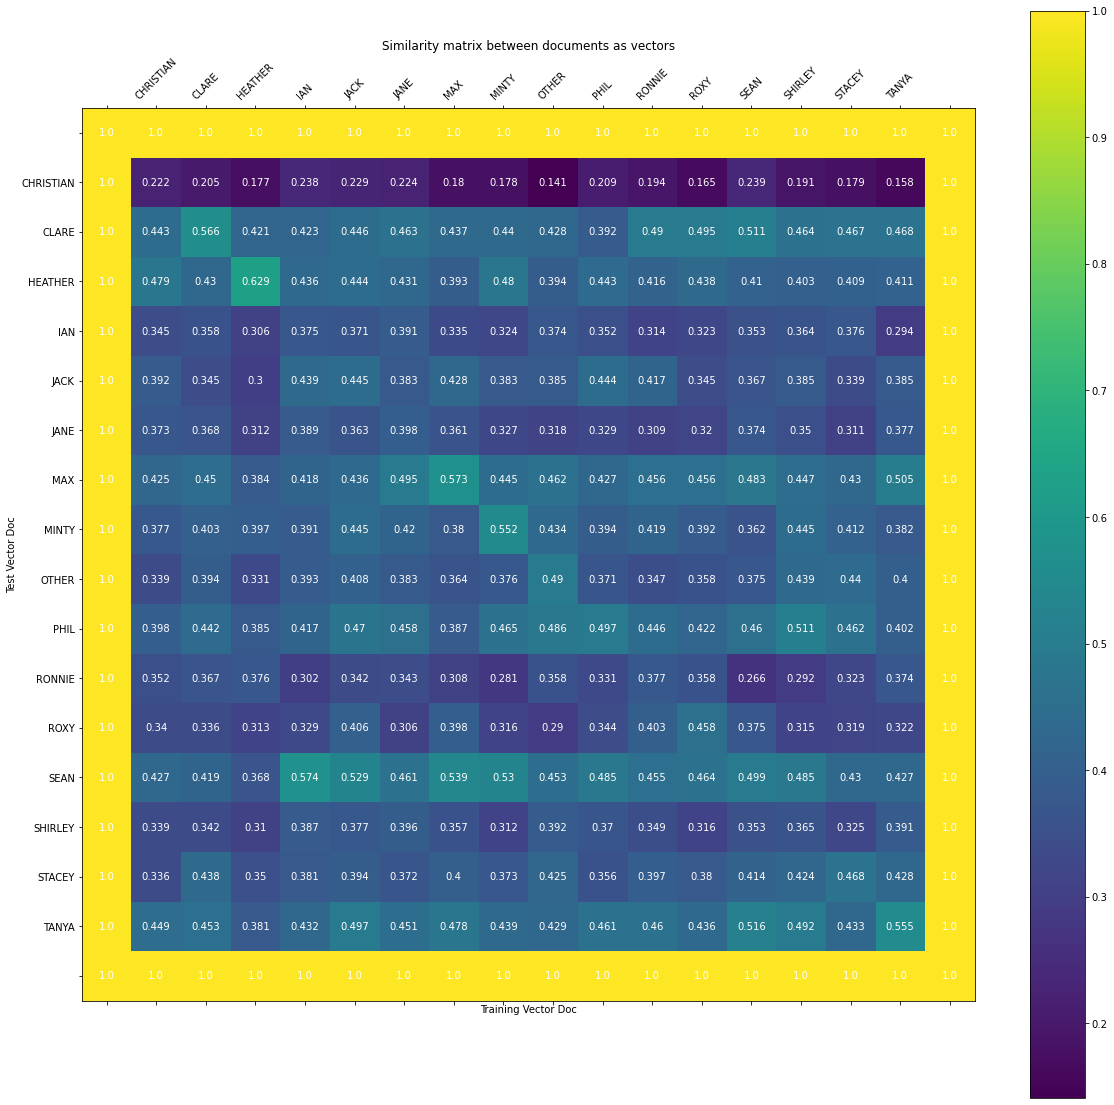

In [16]:
plot_heat_map_similarity(df)

## 2. Improve linguistic feature extraction
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [17]:
from nltk.tag import CRFTagger
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiahao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# Prepare to adjust features' weights

def to_feature_vector_dictionary(character_doc, extra_features=[], wei1 = 0.2, wei2 = 0.2):

    features={}
    counts = Counter(character_doc)
    counts = dict(counts)
    
    # POS_tag
    pos_tag = {}
    pos = posttagger.tag(character_doc) 
    for i in pos:
        if i[1] in pos_tag:
            pos_tag[i[1]] += 1
        else:
            pos_tag[i[1]] = 1

            
    # Sentiment Analysis
    sen_score = {}
    pos = []
    neg = []
    for i in character_doc:
        if sia.polarity_scores(i)['pos'] > 0:
            pos.append(sia.polarity_scores(i)['pos'])
        elif sia.polarity_scores(i)['neg'] > 0:
            neg.append(sia.polarity_scores(i)['neg'])
    sen_score['pos'] = sum(pos)
    sen_score['neg'] = sum(neg)
    
    
    # Gender Analysis
#     name_1 = name
#     gen_feature = {}
#     gen_feature[gender_feature(name_1)] = 1
        
    # Weights Adjustment
    sen_score = weights(sen_score, wei1)
    pos_tag = weights(pos_tag, wei2)
    features = (pos_tag|sen_score|counts)
    
    return features

## 3. Add dialogue context data and features
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). We can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

In [19]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    
    character_docs = {}
    character_line_count = {}
    
    for line, name, gender in zip(range(len(df.Line)), df.Character_name, df.Gender): 
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name] == max_line_count:
            continue
        character_docs[name] += str(df.Line.iloc[line]) +'.'
        character_line_count[name]+=1
        
#         # Next Sentence
#         if line < len(df.Line):
#             character_docs[name] += str(df.Line.iloc[line+1]) 
    
#         # Prev Sentence
#         if line > 1:
#             character_docs[name] += str(df.Line.iloc[line-1]) 
        
        # Episode
        character_docs[name] += str(df.Episode.iloc[line]) 
        # Scene
        character_docs[name] += str(df.Scene.iloc[line]) 
        
#         # Scene_info
#         character_docs[name] += str(df.Scene_info.iloc[line])
        
        
    print("lines per character", character_line_count)
    return character_docs

In [20]:
create_character_document_from_dataframe(train_data, max_line_count=3)

lines per character {'SHIRLEY': 3, 'OTHER': 3, 'JACK': 3, 'RONNIE': 3, 'TANYA': 3, 'SEAN': 3, 'ROXY': 3, 'HEATHER': 3, 'MAX': 3, 'IAN': 3, 'JANE': 3, 'STACEY': 3, 'PHIL': 3, 'MINTY': 3, 'CHRISTIAN': 3, 'CLARE': 3}


{'SHIRLEY': "Look at ya, not a mark on ya. And you think you're an unlucky man..13501I'm gonna get help. Oh where's my phone? Oh Kevin. Kevin you smashed it, didn't ya? Kevin, Kevin, where's your phone?.13504No you're not, ssh, shut up..13504",
 'OTHER': 'Shirl....13501Where you going?.13504In my right pocket..13504',
 'JACK': "Oi. Where have you been? Huh? What were the texts about?.13502Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar..13502It's on the house. Are you alright?.135024",
 'RONNIE': "Nothing. Nothing. I'll be with you in two minutes yeah?.13502Alright. Two minutes..13502Okay..135024",
 'TANYA': "Another drink?.13506Lightweight. Let's see what we got over here shall we? Oh look it's 21 year old whisky. Let's have that shall we? Max prefers them younger..13506That's my Seany Sean Sean. No point going to bed early on New Year's Eve is there?.13506",
 'SEAN': "No. I'm pretty wasted as it goes..13506In for a penny..13506Tany

## 4. Improve the vectorization method
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure we initialize any transformers we want to try in the same place as `corpusVectorizer = DictVectorizer()` before we call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique we try.

In [21]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
mean rank 2.1875
mean cosine similarity 0.839344695812493
10 correct out of 16 / accuracy: 0.625


In [22]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
print (training_feature_matrix)

  (0, 0)	0.4
  (0, 1)	1.6
  (0, 2)	0.2
  (0, 4)	0.4
  (0, 5)	8.2
  (0, 6)	0.2
  (0, 7)	0.4
  (0, 8)	0.2
  (0, 10)	19.6
  (0, 11)	187.6
  (0, 14)	0.4
  (0, 15)	1.0
  (0, 16)	0.2
  (0, 17)	0.6
  (0, 19)	8.2
  (0, 20)	0.4
  (0, 22)	0.8
  (0, 23)	11.8
  (0, 24)	9.2
  (0, 25)	0.2
  (0, 27)	0.4
  (0, 28)	3.6
  (0, 30)	0.2
  (0, 32)	0.2
  (0, 44)	1.0
  :	:
  (15, 2888)	3.0
  (15, 2892)	2.0
  (15, 2901)	1.0
  (15, 2906)	1.0
  (15, 2907)	8.0
  (15, 2909)	5.0
  (15, 2912)	1.0
  (15, 2915)	5.0
  (15, 2919)	1.0
  (15, 2933)	1.0
  (15, 2940)	1.0
  (15, 2944)	1.0
  (15, 2950)	1.0
  (15, 2953)	1.0
  (15, 2954)	5.0
  (15, 2957)	2.0
  (15, 2966)	1.0
  (15, 2967)	2.0
  (15, 2972)	14.0
  (15, 2973)	11.0
  (15, 2974)	5.0
  (15, 2978)	1.0
  (15, 2979)	4.0
  (15, 2984)	1.0
  (15, 2985)	1.0


In [23]:
# new
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer

def create_document_matrix_from_corpus(corpus, fitting=False, wei1 = 0.2, wei2 = 0.2):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, wei1, wei2) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, wei1, wei2) for name, doc in corpus])
    
    feature_matrix = tfidf_transformer.fit_transform(doc_feature_matrix)
    
#     X = feature_matrix
#     y = [name for name, doc in corpus]
#     k = 1
#     X_new = SelectKBest(chi2, k=k).fit_transform(X, y)
#     print ('the number of original features is {0}, the number of new features {1}'.format(X.shape, X_new.shape))

    return feature_matrix
 

In [24]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
print (training_feature_matrix)

  (0, 2986)	0.014426504460453855
  (0, 2979)	0.015032549004674156
  (0, 2974)	0.00974572193119978
  (0, 2973)	0.09188662728297947
  (0, 2971)	0.014426504460453855
  (0, 2967)	0.005169372317458025
  (0, 2966)	0.009379115565586474
  (0, 2958)	0.017341792524902425
  (0, 2957)	0.004594331364148973
  (0, 2954)	0.03216031954904281
  (0, 2953)	0.005486348430833224
  (0, 2951)	0.014064426761414835
  (0, 2950)	0.005486348430833224
  (0, 2947)	0.014426504460453855
  (0, 2940)	0.006594326832309731
  (0, 2938)	0.007516274502337078
  (0, 2937)	0.006594326832309731
  (0, 2936)	0.014426504460453855
  (0, 2933)	0.007032213380707418
  (0, 2921)	0.01256366339720446
  (0, 2915)	0.004594331364148973
  (0, 2911)	0.014426504460453855
  (0, 2909)	0.016459045292499672
  (0, 2907)	0.036754650913191786
  (0, 2906)	0.009379115565586474
  :	:
  (15, 69)	0.021469460475111096
  (15, 64)	0.009755790663212268
  (15, 58)	0.03220419071266664
  (15, 47)	0.010734730237555548
  (15, 37)	0.08587784190044438
  (15, 31)	0.00

In [25]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
mean rank 1.3125
mean cosine similarity 0.5909458100116041
14 correct out of 16 / accuracy: 0.875


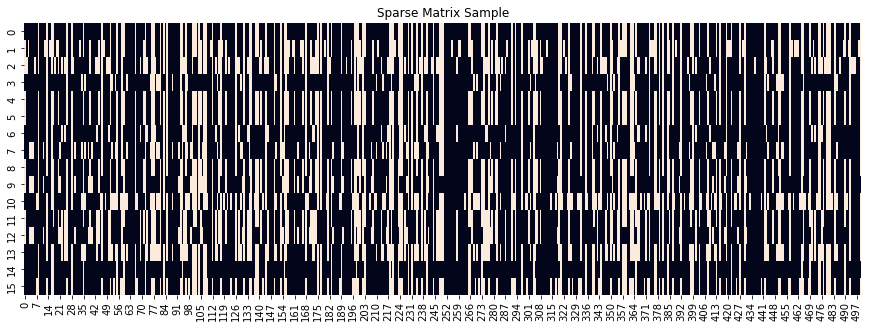

In [26]:
#visualise the feature matrix and training corpus 
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(training_feature_matrix.todense()
            [:,np.random.randint(0,len(training_corpus),500)]==0, 
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [27]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
mean rank 1.3125
mean cosine similarity 0.5909458100116041
14 correct out of 16 / accuracy: 0.875


## 5. Select and test the best vector representation method
Finish the optimization of our vector representations by selecting the best combination of the techniques we tried in 1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime we developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure our best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [28]:
#linguistic feature selection

# i = 0
# score = {}
# score_df = pd.DataFrame(columns = ['wei1', 'wei2', 'mean_rank', 'mean_cosine_simliarity', 'acc'])
# for wei1 in np.arange(0,1,0.1):
#     for wei2 in np.arange(0,1,0.1):
#         training_feature_matrix = create_document_matrix_from_corpus(
#             training_corpus, fitting=True, wei1 = wei1, wei2 = wei2)
        
#         val_feature_matrix = create_document_matrix_from_corpus(
#             val_corpus, fitting=False, wei1 = wei1, wei2 = wei2)
        
#         mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(
#             training_feature_matrix, val_feature_matrix, train_labels, val_labels)
        
#         score_df.loc[i] = [wei1]+[wei2]+ [mean_rank]+ [mean_cosine_simliarity]+[acc]
#         i += 1
        
# score_df.sort_values('mean_cosine_simliarity',ascending = False).head(10)

*dialogue context selection*
- Original: 0.8125
- Prev: 0.625
- Prev + Next: 0.6875
- Episode: 0.875
- Episode + Scene: 0.875
- Episode + Scene + Scene_info: 0.625

In [29]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, wei1 = 0.2, wei2 = 0.2)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, wei1 = 0.2, wei2 = 0.2)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  3434
OTHER Number of Words:  2807
JACK Number of Words:  3987
RONNIE Number of Words:  3073
TANYA Number of Words:  3415
SEAN Number of Words:  3227
ROXY Number of Words:  3401
HEATHER Number of Words:  3705
MAX Number of Words:  4308
IAN Number of Words:  4064
JANE Number of Words:  3318
STACEY Number of Words:  3526
PHIL Number of Words:  3304
MINTY Number of Words:  3592
CHRISTIAN Number of Words:  3481
CLARE Number of Words:  4045
total words 56687
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  